In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import os
import pandas as pd
import re
import sqlite3
import importlib
from findercode.vnt_functions import AA_translator
from findercode.vnt_functions import sub_nones_empty
from findercode.vnt_functions import graphing
from findercode.filename import get_filename
from findercode.filename import read_ini_table
from findercode.subset import get_variant_data
from findercode.subset import subset_dataframe
from findercode.get_groups import get_groups
from findercode.variants import GetVariants
from findercode.variants import SepGroups
from findercode.variants import Variant
from findercode.variants import VntCount
from findercode.variants import ConstFullName

### For DEMO please use: example.xlsx

In [2]:
df = read_ini_table(table_name=get_filename())
df.head()

Please enter the name of the excel table of your interest in the format, Name.xlsx:  example.xlsx


,Gene,Mutation Name,DNA Sequence Variation,Tumor Site,Gender,Race
53,CDH1,p.R335*,c.1003C>T,BREAST,F,White
143,CDH1,,c.1008+8G>T,Endometrium,F,White
122,CDH1,p.E336D,c.1008G>C,BREAST,F,White
155,CDH1,p.S337_splice,c.1009_splice,LUNG,M,White
52,CDH1,p.A34Efs*23,c.100_104delGCCGA,BREAST,F,White


### Let's create an instance of the class GetVariants 

In [3]:
v = GetVariants()
print(v)
#type(v)

Variant types:
c_change: 0
c_fs: 0
c_splice: 0
g_name: 0
p_FS: 0
p_change: 0



### Clean up initial data: Capture the acceptable variants, drop duplicates, sort values, etc.

In [4]:
v = get_variant_data(df)
print(v)

<class 'findercode.variants.GetVariants'>
Variant types:
c_change: 118
c_fs: 52
c_splice: 9
g_name: 190
p_FS: 50
p_change: 119



### Create three different dataframes with the captured variants 

In [5]:
df1, df2, df3 = subset_dataframe(df, v)

In [6]:
df2.head()

,Gene,Mutation Name,DNA Sequence Variation,Tumor Site,Gender,Race
52,CDH1,p.A34Efs*23,c.100_104delGCCGA,BREAST,F,White
204,CDH1,p.F338fs,c.1013_1014TC>T,STOMACH,M,Unknown - Declined
106,CDH1,p.N369Tfs*26,c.1098_1099insGACAC,BREAST,F,White
41,CDH1,p.L396fs,c.1188_1189GA>G,BREAST,F,White
51,CDH1,p.D433fs,c.1298_1306ATGGCATTT>AA,BREAST,F,White


### From the cleaned new dataframes, using regex, capture the different components that make-up the variants' p. and c. names

In [7]:
s = get_groups(df1, df2, df3)
print(s)

<class 'findercode.variants.SepGroups'>
No. of variants found per Group (name components):
CdnaFS: 50
Cdna_snv: 118
Cdnaspl: 9
FSstop_pos: 50
WTBsnv: 118
WTBspl: 9
c_fs2: 50
c_splice3: 9
codonFS: 50
codon_snv: 118
offset_pos: 9
p_change1: 118
p_fs2: 50
raw_WTBFS: 50
raw_vnt_BFS: 50
vnt_AA: 118
vnt_AAFS: 50
vnt_Bsnv: 118
vnt_Bspl: 9
wtaa: 118
wtaaFS: 50



#### Substitute value None for string None in vnt_AAFS

In [8]:
s["vnt_AAFS"] = ['None' if v is None else v for v in s["vnt_AAFS"]]
print(s["vnt_AAFS"])

['E', 'None', 'T', 'None', 'None', 'None', 'None', 'None', 'S', 'C', 'None', 'K', 'None', 'None', 'None', 'None', 'Q', 'S', 'K', 'H', 'None', 'K', 'H', 'None', 'S', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'R', 'None', 'None', 'None', 'R', 'None', 'None', 'H', 'None', 'None', 'None', 'None', 'None', 'I']


### Extracting the translator from the module, translate one letter AA code to the three letter code
 * ex: translate A for Ala
 * Get WTAA and VAA

In [9]:
WTAA_FS = AA_translator(s["wtaaFS"])
vnt_AA_3codeFS = AA_translator(s["vnt_AAFS"])
WTAAsnv = AA_translator(s["wtaa"])
vnt_AA_3code = AA_translator(s["vnt_AA"])


# print(WTAA_FS)
# print(vnt_AA_3codeFS)
# print(WTAAsnv)
# print(vnt_AA_3code)

### Add "fs" string to the 3 letter code to start forming the full name

In [10]:
s["FSstop_pos"]  # this is fs list
vnt_AA_3codeFS

vntAA3addFS = []
if len(s["FSstop_pos"]) == len(vnt_AA_3codeFS):
    for ind in range(len(vnt_AA_3codeFS)):
        if vnt_AA_3codeFS[ind] == 'None':
            vntAA3addFS.append(s["FSstop_pos"][ind])
        else:
            vntAA3addFS.append(vnt_AA_3codeFS[ind] + s["FSstop_pos"][ind])
# print(vntAA3addFS)

### Substitute value None for empty string 
(This is just a clean up step for other functionality)

In [11]:
WTBFS = sub_nones_empty(s["raw_WTBFS"])
# print(WTBFS)

vnt_BFS = sub_nones_empty(s["raw_vnt_BFS"])
# print(vnt_BFS)

### Generate variants full name in compliance with HGVS nomenclature standards 

In [12]:
n = ConstFullName()
print(n)

Variant names' types:
pfullname: 0
pfullnameFS: 0
snv_vnt_fullname: 0
vnt_fullnameFS: 0



#### Brian: 
I am sorry this function is here and not in the module. I couldn't figure out how to connect my different instances from different classes.
Since they are just containers, they don't exists outside of the current occurrence, so I wasn't able to add them as variables or objects to the function. I'll investigate more.    

In [13]:
def full_name(WTAAsnv, vnt_AA_3code, WTAA_FS, vntAA3addFS):
    n = ConstFullName()
    print(type(n))
    
    # get full Protein change name with 3 letter AA for snv variants
    n["pfullname"] = ["(p." + WTAAsnv[ind] + s["codon_snv"][ind] + vnt_AA_3code[ind] + ")"  for ind in range(len(s["codon_snv"]))]
    #Create full snv name
    n["snv_vnt_fullname"] = [v["c_change"][ind] + (" ") + n["pfullname"][ind] for ind in range(len(v["c_change"]))]

    # get full Protein change name with 3 letter AA for FS variants
    n["pfullnameFS"] = ["(p." + WTAA_FS[ind] + s["codonFS"][ind] + vntAA3addFS[ind] + ")" for ind in range(len(s["codonFS"]))]
    #Create full FS name
    n["vnt_fullnameFS"] = [s["c_fs2"][ind] + " " + n["pfullnameFS"][ind] for ind in range(len(s["c_fs2"]))]
    return n

In [14]:
n = full_name(WTAAsnv, vnt_AA_3code, WTAA_FS, vntAA3addFS)
#print(n)
#print(n["pfullname"])
print(n["snv_vnt_fullname"])
#print(n["pfullnameFS"])
print(n["vnt_fullnameFS"])



<class 'findercode.variants.ConstFullName'>
['c.1003C>T (p.Arg335*)', 'c.1008G>C (p.Glu336Asp)', 'c.1018A>G (p.Thr340Ala)', 'c.1019C>T (p.Thr340Met)', 'c.1090A>T (p.Thr364Ser)', 'c.1093G>A (p.Val365Ile)', 'c.1108G>A (p.Asp370Asn)', 'c.1149G>C (p.Gln383His)', 'c.1162G>A (p.Glu388Lys)', 'c.1198G>A (p.Asp400Asn)', 'c.1204G>A (p.Asp402Asn)', 'c.1214A>G (p.Asn405Ser)', 'c.1225T>C (p.Trp409Arg)', 'c.1267T>C (p.Phe423Leu)', 'c.1298A>G (p.Asp433Gly)', 'c.1300G>C (p.Gly434Arg)', 'c.1315G>A (p.Ala439Thr)', 'c.1325T>C (p.Leu442Ser)', 'c.1360G>A (p.Val454Ile)', 'c.1394C>G (p.Ser465Cys)', 'c.1417G>A (p.Val473Ile)', 'c.1423G>A (p.Val475Met)', 'c.1454T>C (p.Ile485Thr)', 'c.1475G>C (p.Arg492Thr)', 'c.1524C>G (p.Tyr508*)', 'c.1534G>T (p.Glu512*)', 'c.1565C>T (p.Thr522Ile)', 'c.1578G>A (p.Trp526*)', 'c.1584C>G (p.Asp528Glu)', 'c.161G>A (p.Arg54Lys)', 'c.1769A>G (p.Asp590Gly)', 'c.1774G>A (p.Ala592Thr)', 'c.1792C>T (p.Arg598*)', 'c.1810G>T (p.Glu604*)', 'c.1853A>G (p.Asp618Gly)', 'c.1856T>G (p.Leu619Arg)

### ok, this is just a map of all the lists that we have generated; they contain all the different components of a variant name. 
(run the cell, it assigns the Gene name to its variable)

In [15]:
# From df1 snv variants
n["snv_vnt_fullname"]
Gene_snv = df1.Gene
WTAAsnv
s["codon_snv"]
vnt_AA_3code
s["Cdna_snv"]
s["WTBsnv"]
s["vnt_Bsnv"]

# From df2 FS variants
n["vnt_fullnameFS"]
Gene_FS = df2.Gene
WTAA_FS
s["codonFS"]
vnt_AA_3codeFS
s["CdnaFS"]
WTBFS
vnt_BFS


# From df3 splice variables
s["c_splice3"]
Gene_spl = df3.Gene
s["Cdnaspl"]
s["WTBspl"]
s["vnt_Bspl"]
s["offset_pos"]

['+8', '+2', '+1', '-4', '+1', '+1', '+3', '-1', '-3']

### The next three cells will generate three separate dataframes with all the separated components of a name. These dataframes correspond to the 3 different variant types that we deal with.

In [16]:
snv_Table = pd.DataFrame(list(zip(n["snv_vnt_fullname"], Gene_snv, WTAAsnv, s["codon_snv"], vnt_AA_3code, s["WTBsnv"], s["Cdna_snv"], s["vnt_Bsnv"])),
                         columns=['Variant_Name', 'Gene_Name', 'Wildtype_Amino_Acid', 'Codon', 
                                  'Variant_Amino_Acid', 'Wildtype_Seq', 'Cdna_Position_Number', 'Variant_Seq'])
snv_Table.head()

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1003C>T (p.Arg335*),CDH1,Arg,335,*,C,1003,T
1,c.1008G>C (p.Glu336Asp),CDH1,Glu,336,Asp,G,1008,C
2,c.1018A>G (p.Thr340Ala),CDH1,Thr,340,Ala,A,1018,G
3,c.1019C>T (p.Thr340Met),CDH1,Thr,340,Met,C,1019,T
4,c.1090A>T (p.Thr364Ser),CDH1,Thr,364,Ser,A,1090,T


In [17]:
FS_Table = pd.DataFrame(list(zip(n["vnt_fullnameFS"], Gene_FS, WTAA_FS, s["codonFS"], vnt_AA_3codeFS, WTBFS, s["CdnaFS"], vnt_BFS)),
                        columns=['Variant_Name', 'Gene_Name', 'Wildtype_Amino_Acid', 'Codon', 
                                 'Variant_Amino_Acid', 'Wildtype_Seq', 'Cdna_Position_Number', 'Variant_Seq'])
FS_Table.head()

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.100_104delGCCGA (p.Ala34Glufs*23),CDH1,Ala,34,Glu,,100,GCCGA
1,c.1013_1014TC>T (p.Phe338fs),CDH1,Phe,338,None,TC,1013,T
2,c.1098_1099insGACAC (p.Asn369Thrfs*26),CDH1,Asn,369,Thr,,1098,GACAC
3,c.1188_1189GA>G (p.Leu396fs),CDH1,Leu,396,None,GA,1188,G
4,c.1298_1306ATGGCATTT>AA (p.Asp433fs),CDH1,Asp,433,None,ATGGCATTT,1298,AA


In [18]:
Splice_Table = pd.DataFrame(list(zip(s["c_splice3"], Gene_spl, s["WTBspl"], s["Cdnaspl"], s["vnt_Bspl"])),
                            columns=['Variant_Name', 'Gene_Name', 'Wildtype_Seq', 'Cdna_Position_Number', 
                                     'Variant_Seq'])
Splice_Table.head()

,Variant_Name,Gene_Name,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1008+8G>T,CDH1,G,1008,T
1,c.1137+2T>A,CDH1,T,1137,A
2,c.1320+1G>C,CDH1,G,1320,C
3,c.1321-4C>G,CDH1,C,1321,G
4,c.1565+1G>A,CDH1,G,1565,A


### Here we will join the last three tables to generate the final dataframe with all the variant types, their full name and separated name components.

In [19]:
joining_Tables = snv_Table.append([FS_Table, Splice_Table])
Individual_values_Table = joining_Tables.reindex_axis(snv_Table.columns, axis=1).fillna("")
Individual_values_Table.head()

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1003C>T (p.Arg335*),CDH1,Arg,335,*,C,1003,T
1,c.1008G>C (p.Glu336Asp),CDH1,Glu,336,Asp,G,1008,C
2,c.1018A>G (p.Thr340Ala),CDH1,Thr,340,Ala,A,1018,G
3,c.1019C>T (p.Thr340Met),CDH1,Thr,340,Met,C,1019,T
4,c.1090A>T (p.Thr364Ser),CDH1,Thr,364,Ser,A,1090,T


### We are ready to write these into a database:
   #### Connect to a sqlite3 database and create a table with our generated dataframe:

In [20]:
db_conn = sqlite3.connect(":MEMORY:")
curs = db_conn.cursor()
Individual_values_Table.to_sql(
    "Variant_Ref1", db_conn, index=False, if_exists='replace')

#### Query the table:

In [21]:
sql = "SELECT * FROM Variant_Ref1"
df = pd.read_sql_query(sql, db_conn)
df.head()

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1003C>T (p.Arg335*),CDH1,Arg,335,*,C,1003,T
1,c.1008G>C (p.Glu336Asp),CDH1,Glu,336,Asp,G,1008,C
2,c.1018A>G (p.Thr340Ala),CDH1,Thr,340,Ala,A,1018,G
3,c.1019C>T (p.Thr340Met),CDH1,Thr,340,Met,C,1019,T
4,c.1090A>T (p.Thr364Ser),CDH1,Thr,364,Ser,A,1090,T


In [22]:
curs.execute('SELECT Variant_Name FROM Variant_Ref1 WHERE Codon="340"')
curs.fetchall()

[('c.1018A>G (p.Thr340Ala)',), ('c.1019C>T (p.Thr340Met)',)]

#### close the connection to the database:

In [23]:
db_conn.close()

### Let's create 3 new instances of our class Variant: instances are variants that we want on "spot light" to do more work with them at a later time. 

In [24]:
a = Variant(vname="c.1090A>T (p.Thr364Ser)", gene="CDH1")
print(a)
c = Variant(vname="c.1003C>T (p.Arg335*)", gene="CDH1")
print(c)
d = Variant(vname="c.1018A>G (p.Thr340Ala)", gene="CDH1")
print(d)
d.how_many()

The variant c.1090A>T (p.Thr364Ser), is located in the CDH1 gene
The variant c.1003C>T (p.Arg335*), is located in the CDH1 gene
The variant c.1018A>G (p.Thr340Ala), is located in the CDH1 gene
There are 3 variants to work with.


In [25]:
c.del_variant()

You are deleting the variant c.1003C>T (p.Arg335*)
There are/is 2 more variant(s) to work with.


### Create an instance of the VntCount class, which inherits from the Variant class. 
#### It tells you how many variants are in your final dataframe, and the number of variants on "spot light".  

In [26]:
b = VntCount(vname="c.1090A>T (p.Thr364Ser)", gene="CDH1",
             dataF=Individual_values_Table, dfname="Individual_values_Table")
print(b)

There are 177 CDH1 variants in the Individual_values_Table dataframe.
But you are only working with 3 variants from this table.


### Generate a bar graph from your final dataframe:

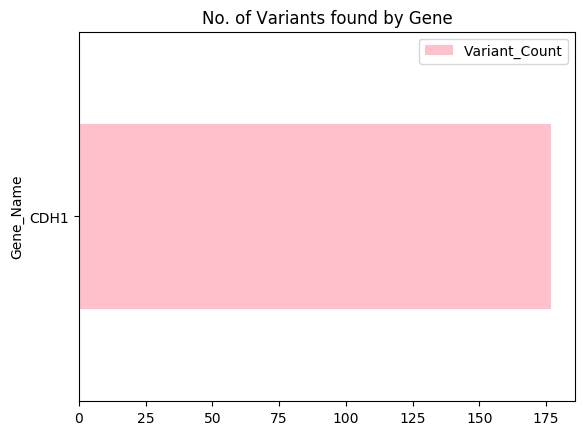

Would you like to save the graph?: yes or no yes

 Ok it is saved!
  Thank you for using Variant Finder. Bye!


In [27]:
graphing(Individual_values_Table)